## Introduction to Exploratory Data Analysis and Visualization

In this lab, we will cover some basic EDAV tools and provide an example using _presidential speeches_.

## Table of Contents

  [  -Step 0: Import modules](#step0)
 
  [-Step 1: Read in the speeches](#step1)
 
  [-Step 2: Text processing](#step2)
 
   -Step 3: Visualization
 
 * [   Step 3.1: Word cloud](#step3-1)

 * [   Step 3.2: Joy plot](#step3-3)
   
  [-Step 4: Sentence analysis](#step4)
 
  [-Step 5: NRC emotion analysis](#step5)

<a id="Example"></a>

## Part 2: Example using _presidential speeches_.

In this section, we will go over an example using a collection of presidential speeches. The data were scraped from the [Presidential Documents Archive](http://www.presidency.ucsb.edu/index_docs.php) of the [American Presidency Project](http://www.presidency.ucsb.edu/index.php) using the `Rvest` package from `R`.  The scraped text files can be found in the `data` folder. 

For the lab, we use a handful of basic Natural language processing (NLP) building blocks provided by NLTK (and a few additional libraries), including text processing (tokenization, stemming etc.), frequency analysis, and NRC emotion analysis. It also provides various data visualizations -- an important field of data science.

<a id="step0"></a>
## Step 0: Import modules 

**Initial Setup** you need Python installed on your system to run the code examples used in this tutorial. This tutorial is constructed using Python 2.7, which is slightly different from Python 3.5. 

We recommend that you use Anaconda for your python installation. For more installation recommendations, please use our [check_env.ipynb](https://github.com/DS-BootCamp-Collaboratory-Columbia/AY2017-2018-Winter/blob/master/Bootcamp-materials/notebooks/Pre-assignment/check_env.ipynb). 

The main modules we will use in this notebook are:
* *nltk*:
  * *nltk* (Natural Language ToolKit) is the most popular Python framework for working with human language. 
  * *nltk* doesn’t come with super powerful pre-trained models, but contains useful functions for doing a quick exploratory data analysis. 
  * [Reference webpage](https://nlpforhackers.io/introduction-nltk/#more-4627)
  * [NLTK book](http://www.nltk.org/book/)
  
* *re* and *string*:
  * For text processing.

* *scikit-learn*:
  * For text feature extraction.
 
* *wordcloud*:
  * Word cloud visualization.
  * Pip installation:
  ```
  pip install wordcloud
  ```
  * Conda installation (not come with Anaconda built-in packages):
  ```
  conda install -c conda-forge wordcloud=1.2.1
  ```

* *ipywidgets*:
  * *ipywidgets* can render interactive controls on the Jupyter notebook. By using the elements in *ipywidgets*, e.g., `IntSlider`, `Checkbox`, `Dropdown`, we could produce fun interactive visualizations.
  * Pip installation:
    If you use pip, you also have to enable the ipywidget extension in your notebook to render it next time you start the notebook. Type in following command on your terminal:
    ```
    pip install ipywidgets
    jupyter nbextension enable --py widgetsnbextension
    ```
  * Conda installation:
    If you use conda, the extension will be enabled automatically. There might be version imcompatible issue happened, following command is to install the modules in the specific compatible versions.
    ```
    conda install --yes jupyter_core notebook nbconvert ipykernel ipywidgets=6.0 widgetsnbextension=2.0
    ```
  * [Reference webpage](https://towardsdatascience.com/a-very-simple-demo-of-interactive-controls-on-jupyter-notebook-4429cf46aabd)


* *seaborn*:
  * *seaborn* provides a high-level interface to draw statistical graphics.
  * A comprehensive [tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial) on it.

In [1]:
# Basic 
from random import randint
import pandas as pd
import csv
import numpy as np
from collections import OrderedDict, defaultdict, Counter

# Text
import nltk, re, string
from nltk.corpus.reader.plaintext import PlaintextCorpusReader #Read in text files
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Plot
import ipywidgets as widgets
import seaborn as sns
from ipywidgets import interactive, Layout, HBox, VBox
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm

# Source code
import sys
sys.path.append("../lib/")
import joypy

<a id="step1"></a>
## Step 1: Read in the speeches

In [2]:
inaug_corpus = PlaintextCorpusReader("../data/inaugurals", ".*\.txt")

#Accessing the name of the files of the corpus
inaug_files = inaug_corpus.fileids()

for f in inaug_files[:5]:
    print(f)

len(inaug_files)

inaugAbrahamLincoln-1.txt
inaugAbrahamLincoln-2.txt
inaugAndrewJackson-1.txt
inaugAndrewJackson-2.txt
inaugBarackObama-1.txt


58

In [3]:
#Accessing all the text of the corpus
inaug_all_text = inaug_corpus.raw()
print("First 100 words in all the text of the corpus: \n >>" + inaug_all_text[:100])

#Accessing all the text for one of the files
inaug_ZacharyTaylor1_text=inaug_corpus.raw('inaugZacharyTaylor-1.txt')
print("First 100 words in one file: \n >>" + inaug_ZacharyTaylor1_text[:100])

First 100 words in all the text of the corpus: 
 >> Fellow-Citizens of the United States:In compliance with a custom as old as the Government itself, I
First 100 words in one file: 
 >> Elected by the American people to the highest office known to our laws, I appear here to take the o


<a id="step2"></a>
## Step 2: Text processing

For the speeches, we do the text processing as follows and define a function `tokenize_and_stem`:
1. convert all letters to lower cases
2. split text into sentences and then words
3. remove [stop words](https://github.com/arc12/Text-Mining-Weak-Signals/wiki/Standard-set-of-english-stopwords), remove empty words due to formatting errors, and remove punctuation.
4. [stemming words](https://en.wikipedia.org/wiki/Stemming) use NLTK porter stemmer. There are [many other stemmers](http://www.nltk.org/howto/stem.html) built in NLTK. You can play around and see the difference.

Then we compute the [Document-Term Matrix (DTM)](https://en.wikipedia.org/wiki/Document-term_matrix) and [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). 

See [Natural Language Processing with Python](http://www.nltk.org/book/) for a more comprehensive discussion about NLTK. 

There are many more interesting topics in NLP, which we will not cover in this lab. In you are interested, here are some online resources.

1. [Named Entity Recognition](https://github.com/charlieg/A-Smattering-of-NLP-in-Python)
2. [Topic modeling](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)
3. [sentiment analysis](https://pythonspot.com/python-sentiment-analysis/)   (positive v.s. negative)
3. [Supervised model](https://www.dataquest.io/blog/natural-language-processing-with-python/)

**TF - IDF**

TF-IDF (term frequency-inverse document frequency) is a numerical statistics that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval, text mining, and user modeling. The TF-IDF value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

$$
\begin{aligned}
\mbox{TF}(t) &=\frac{\mbox{Number of times term $t$ appears in a document}}{\mbox{Total number of terms in the document}}\\
\mbox{IDF}(t) &=\log{\frac{\mbox{Total number of documents}}{\mbox{Number of documents with term $t$ in it}}}\\
\mbox{TF-IDF}(t) &=\mbox{TF}(t)\times\mbox{IDF}(t)
\end{aligned}
$$

In [5]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_and_stem, 
                             stop_words='english', 
                             decode_error='ignore')

tfidf_matrix = vectorizer.fit_transform(token_dict.values()) 
   # The above line can take some time (about < 60 seconds)
feature_names = vectorizer.get_feature_names()

In [7]:
num_samples, num_features=tfidf_matrix.shape
print("num_samples:  %d, num_features: %d" %(num_samples,num_features))
num_clusters=10

num_samples:  58, num_features: 6173


In [8]:
## Checking
print('first term: ' + feature_names[0])
print('last term: ' + feature_names[len(feature_names) - 1])

for i in range(0, 4):
    print('random term: ' + 
          feature_names[randint(1,len(feature_names) - 2)] )

first term: 14th
last term: zone
random term: roman
random term: inner
random term: collect
random term: menw


In [10]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

print(inaug_files[2:3])
print(top_feats_in_doc(tfidf_matrix, feature_names, 3, 10))

['inaugAndrewJackson-1.txt']
    features     score
0     govern  0.239686
1      union  0.206277
2      state  0.170715
3    preserv  0.155504
4    exercis  0.145531
5      peopl  0.132392
6      power  0.123991
7    proport  0.118100
8      gener  0.113810
9  constitut  0.107172


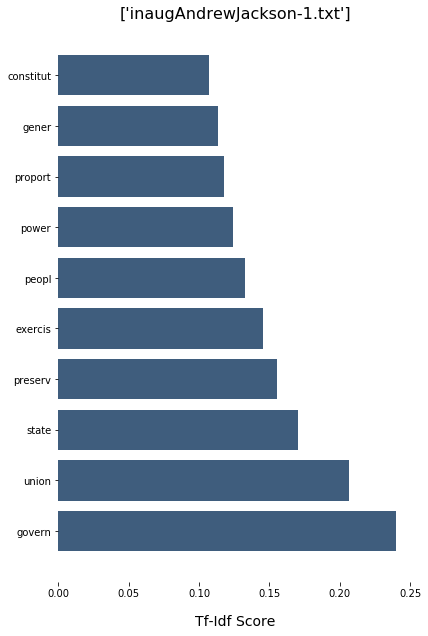

In [11]:
d =3
top_tfidf = top_feats_in_doc(tfidf_matrix, feature_names, d, 10)

def plot_tfidf_classfeats_h(df, doc):
    ''' Plot the data frames returned by the function tfidf_feats_in_doc. '''
    x = np.arange(len(df))
    fig = plt.figure(figsize=(6, 9), facecolor="w")
    ax = fig.add_subplot(1, 1, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title(doc, fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.barh(x, df.score, align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, x[-1]+1])
    yticks = ax.set_yticklabels(df.features)
    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
        
plot_tfidf_classfeats_h(top_tfidf, inaug_files[(d-1):d])

<a id="step3-1"></a>
## Step 3: Visualization

Data visualization is an integral part of the data science workflow. In the following, we use simple data visualizations to reveal some interesting patterns in our data. 

### 1 . Word cloud

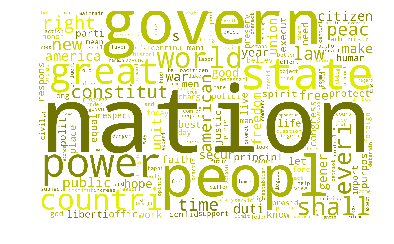

In [12]:
array_for_word_cloud = []
word_count_array = dtm.sum(0)
for idx, word in enumerate(feature_names):
    array_for_word_cloud.append((word,word_count_array[idx]))
    
def random_color_func(word=None, font_size=None, 
                      position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

array_for_word_cloud = dict(array_for_word_cloud)

wordcloud = WordCloud(background_color='white',
          width=1600,
          height=1000,
          color_func=random_color_func).generate_from_frequencies(array_for_word_cloud)
%matplotlib inline
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Let us try making it interactive.

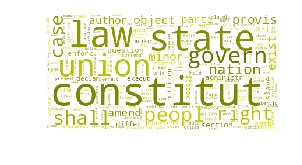

In [13]:
word_cloud_dict = {}
counter = 0 

for fileid in inaug_corpus.fileids():
    row = dtm[counter,:]
    word_cloud_dict[fileid] = []
    for idx, word in enumerate(feature_names):
        word_cloud_dict[fileid].append((word,row[idx]))
    counter += 1

def f_wordclouds(t):
    df_dict = dict(word_cloud_dict[t])
    wordcloud = WordCloud(background_color='white',
          color_func=random_color_func).generate_from_frequencies(df_dict)

    plt.figure(figsize=(3, 3), dpi=100)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

interactive_plot_1 = interactive(f_wordclouds, t=widgets.Dropdown(options=inaug_corpus.fileids(),description='text1'))
interactive_plot_2 = interactive(f_wordclouds, t=widgets.Dropdown(options=inaug_corpus.fileids(),description='text2'))

# Define the layout here.
hbox_layout = Layout(display='flex', flex_flow='row', justify_content='space-between', align_items='center')
vbox_layout = Layout(display='flex', flex_flow='column', justify_content='space-between', align_items='center')

%matplotlib inline
HBox([interactive_plot_1,interactive_plot_2])

<a id="step3-3"></a>
### 2. Joy plot

The following joy plot allows us to compare the frequencies of the top 10 most frequent words in individual speeches.

Index(['nation', 'govern', 'peopl', 'state', 'power', 'great', 'countri',
       'world', 'shall', 'everi'],
      dtype='object')


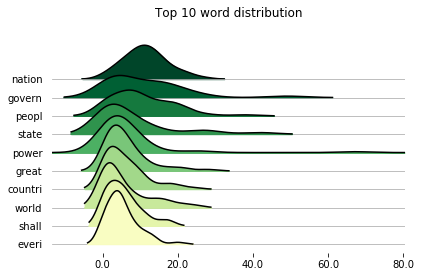

In [14]:
joy_df = pd.DataFrame(dtm, columns=feature_names)
selected_words = joy_df.sum(0).sort_values(ascending=False).head(10).index
print(selected_words)

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
fig, axes = joypy.joyplot(joy_df.loc[:,selected_words],
                            range_style='own', grid="y",
                            colormap=cm.YlGn_r,
                            title="Top 10 word distribution")

<a id="step4"></a>
##  Step 4:  Sentence analysis 

In the previous sections, we focused on word-level distributions in inaugural speeches. Next, we will use sentences as our units of analysis, since they are natural languge units for organizing thoughts and ideas. 

For simpler visualization, we chose a subset of better known presidents or presidential candidates on whom to focus our analysis. 

In [15]:
filter_comparison=["DonaldJTrump","JohnMcCain", "GeorgeBush", "MittRomney", "GeorgeWBush",
                 "RonaldReagan","AlbertGore,Jr", "HillaryClinton","JohnFKerry", 
                 "WilliamJClinton","HarrySTruman", "BarackObama", "LyndonBJohnson",
                 "GeraldRFord", "JimmyCarter", "DwightDEisenhower", "FranklinDRoosevelt",
                 "HerbertHoover","JohnFKennedy","RichardNixon","WoodrowWilson", 
                 "AbrahamLincoln", "TheodoreRoosevelt", "JamesGarfield", 
                 "JohnQuincyAdams", "UlyssesSGrant", "ThomasJefferson",
                 "GeorgeWashington", "WilliamHowardTaft", "AndrewJackson",
                 "WilliamHenryHarrison", "JohnAdams"]

### Nomination speeches 

Next, we first look at the *nomination acceptance speeches* at major parties' national conventions. 

Following the same procedure in [step 1](#step1), we will use `pandas` dataframe to store the nomination speech sentences. For each sentence in a speech (`fileid`), we find out the name of the president (`president`) and the term (`term`), and also calculated the number of words in each sentence as *sentence length* (`word_count`) by using a self-defined function `word_count`.

In [16]:
def word_count(string):
    tokens = [word for word in nltk.word_tokenize(string)]
    counter = 0
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            counter += 1
    return counter

nomin_corpus = PlaintextCorpusReader("../data/nomimations", ".*\.txt")
nomin_files = nomin_corpus.fileids()
nomin_file_df = pd.DataFrame(columns=["file_id","president","term","raw_text"])

for fileid in nomin_corpus.fileids():
    nomin_file_df = nomin_file_df.append({"file_id": fileid,
                              "president": fileid[0:fileid.find("-")][5:],
                              "term": fileid.split("-")[-1][0],
                              "raw_text": nomin_corpus.raw(fileid)}, ignore_index=True)

sentences = []
for row in nomin_file_df.itertuples():
    for sentence in sent_tokenize(row[4]):
        sentences.append({"file_id": row[1],
                          "president": row[2],
                          "term": row[3],
                          "sentence": sentence})
nomin_sen_df = pd.DataFrame(sentences, columns=["file_id","president","term","sentence"])
nomin_sen_df["word_count"] = [word_count(sentence) for sentence in nomin_sen_df["sentence"]]

#### First term

For comparison between presidents, we first limit our attention to speeches for the first terms of former U.S. presidents. We noticed that a number of presidents have very short sentences in their nomination acceptance speeches.

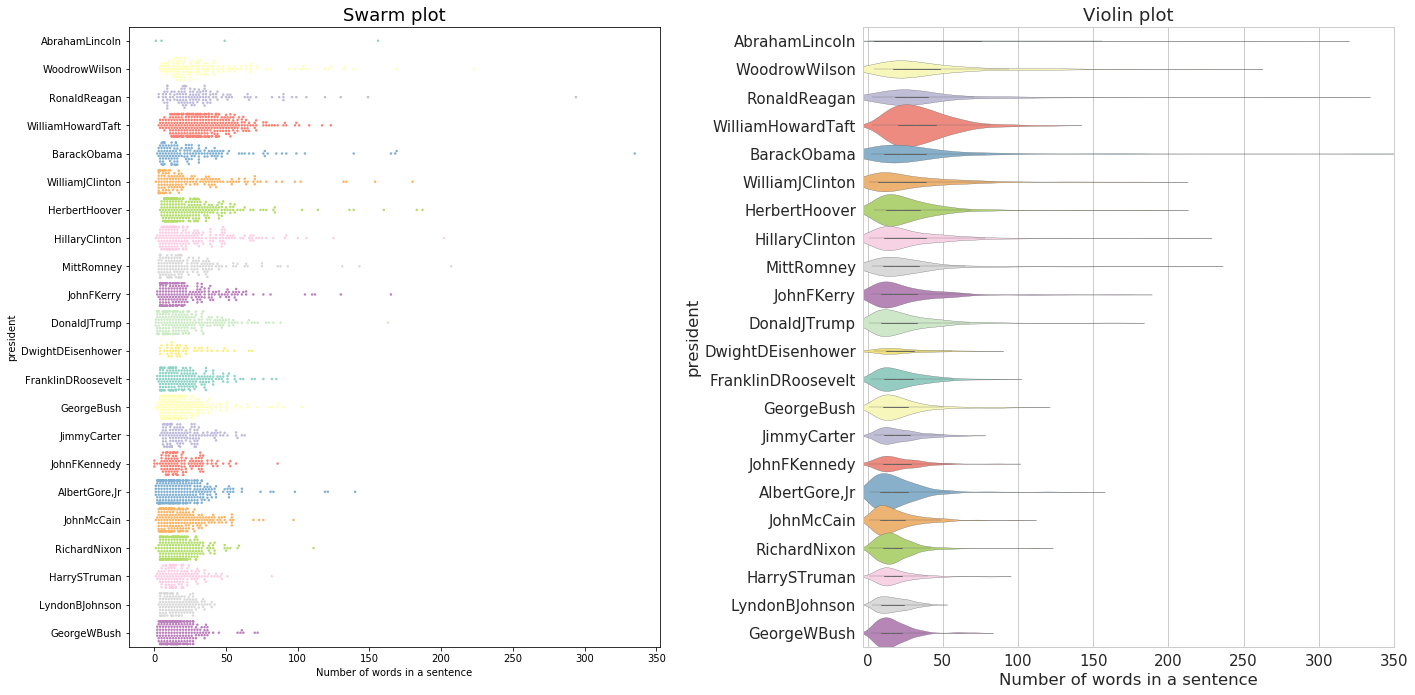

In [17]:
filtered_nomin_sen_df = nomin_sen_df.loc[(nomin_sen_df["president"].isin(filter_comparison))&(nomin_sen_df["term"]=='1')]
filtered_nomin_sen_df = filtered_nomin_sen_df.reset_index()
filtered_nomin_sen_df['group_mean'] = filtered_nomin_sen_df.groupby('president')['word_count'].transform('mean')
filtered_nomin_sen_df = filtered_nomin_sen_df.sort_values('group_mean', ascending=False)

%matplotlib inline
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

plt.subplot(gs[0])
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.swarmplot(y='president', x='word_count', 
              data=filtered_nomin_sen_df,
              palette = "Set3",
              size=2.5, 
              orient='h'). set(xlabel='Number of words in a sentence')
plt.title("Swarm plot")

plt.subplot(gs[1])
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.violinplot(y='president', x='word_count', 
              data=filtered_nomin_sen_df,
              palette = "Set3", cut = 3,
              width=1.5, saturation=0.8, linewidth= 0.3, scale="count",
              orient='h').set(xlabel='Number of words in a sentence')
plt.title("Violin plot")
plt.xlim(-3, 350)
plt.tight_layout()

#### Second term

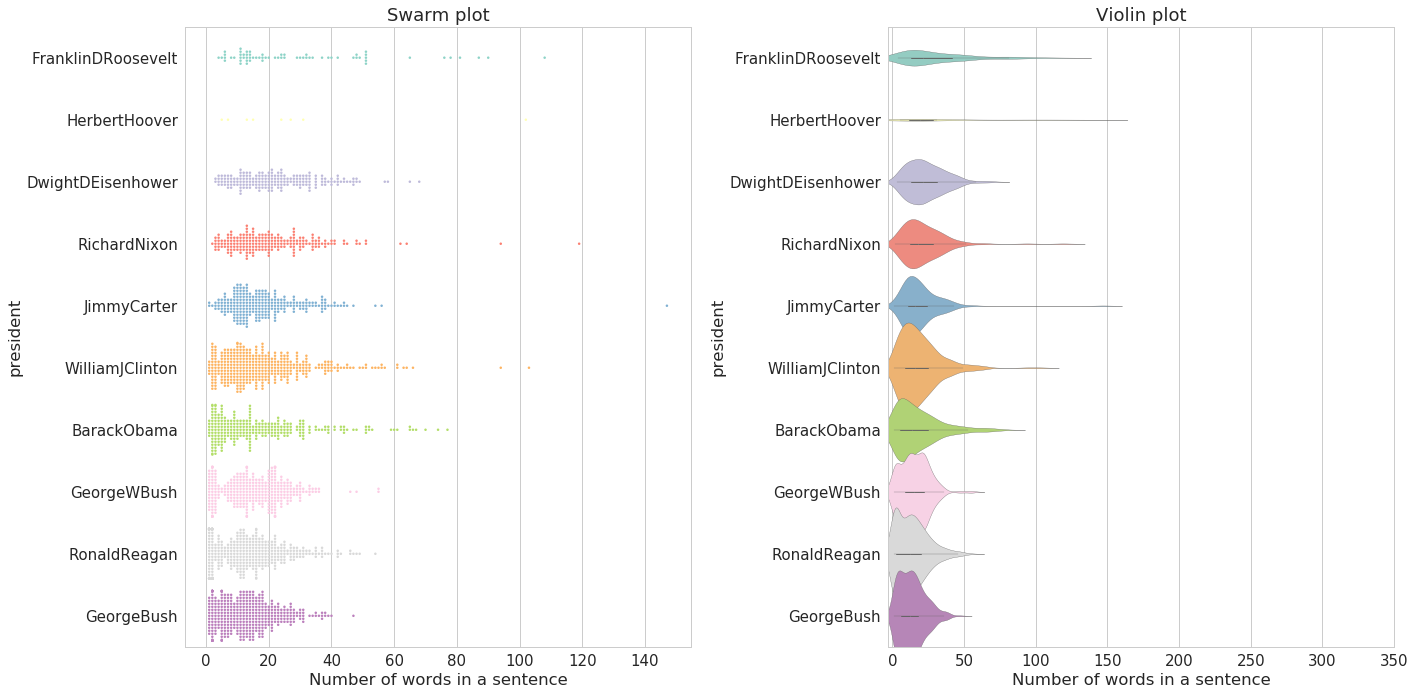

In [18]:
filtered_nomin_sen_df = nomin_sen_df.loc[(nomin_sen_df["president"].isin(filter_comparison))&(nomin_sen_df["term"]=='2')]
filtered_nomin_sen_df = filtered_nomin_sen_df.reset_index()
filtered_nomin_sen_df['group_mean'] = filtered_nomin_sen_df.groupby('president')['word_count'].transform('mean')
filtered_nomin_sen_df = filtered_nomin_sen_df.sort_values('group_mean', ascending=False)

%matplotlib inline
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

plt.subplot(gs[0])
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.swarmplot(y='president', x='word_count', 
              data=filtered_nomin_sen_df,
              palette = "Set3",
              size=2.5, 
              orient='h'). set(xlabel='Number of words in a sentence')
plt.title("Swarm plot")

plt.subplot(gs[1])
sns.violinplot(y='president', x='word_count', 
              data=filtered_nomin_sen_df,
              palette = "Set3", cut = 3,
              width=1.5, saturation=0.8, linewidth= 0.3, scale="count",
              orient='h').set(xlabel='Number of words in a sentence')
plt.title("Violin plot")
plt.xlim(-3, 350)
plt.tight_layout()

### Inaugural speeches

We notice that the sentences in inaugural speeches are longer than those in nomination acceptance speeches. 

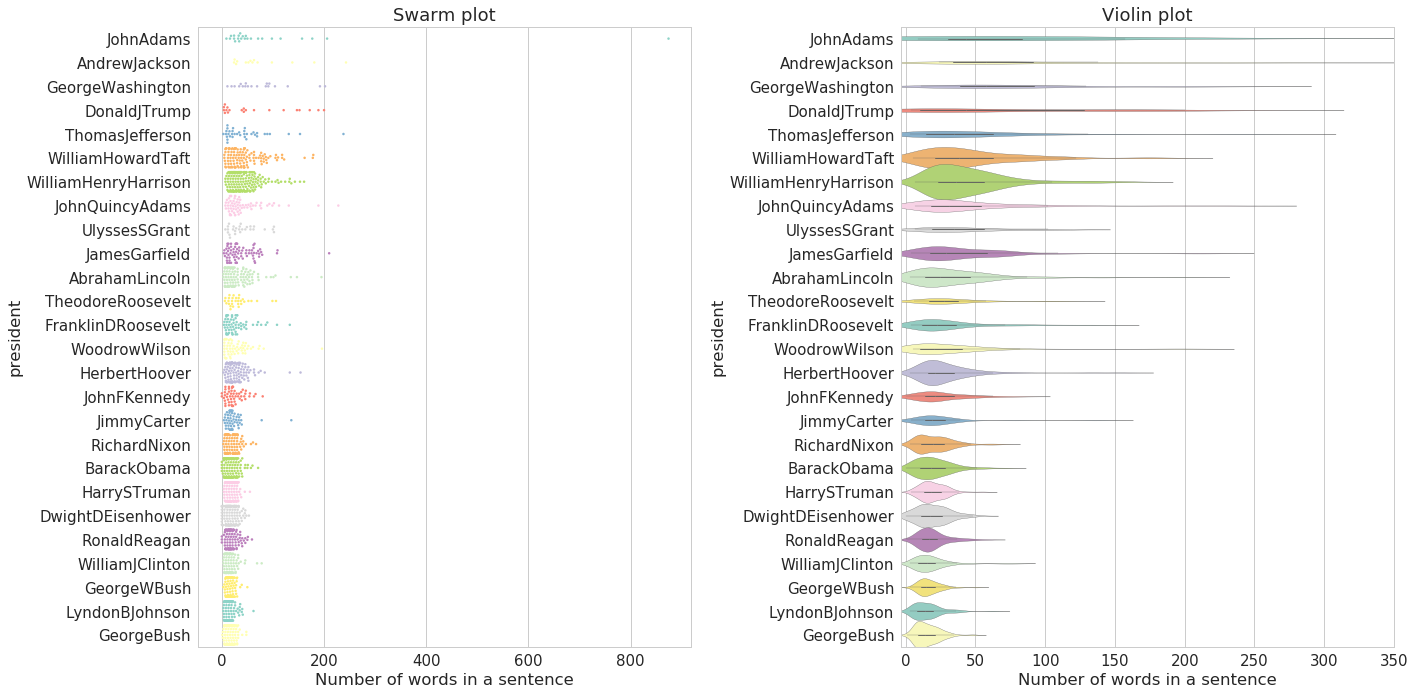

In [19]:
inaug_file_df = pd.DataFrame(columns=["file_id","president","term","raw_text"])

for fileid in inaug_corpus.fileids():
    inaug_file_df = inaug_file_df.append({"file_id": fileid,
                              "president": fileid[0:fileid.find("-")][5:],
                              "term": fileid.split("-")[-1][0],
                              "raw_text": inaug_corpus.raw(fileid)}, ignore_index=True)

sentences = []
for row in inaug_file_df.itertuples():
    for sentence in sent_tokenize(row[4]):
        sentences.append({"file_id": row[1],
                          "president": row[2],
                          "term": row[3],
                          "sentence": sentence})
inaug_sen_df = pd.DataFrame(sentences, columns=["file_id","president","term","sentence"])
wordCounts = [word_count(sentence) for sentence in inaug_sen_df["sentence"]]
inaug_sen_df["word_count"] = wordCounts

filtered_inaug_sen_df = inaug_sen_df.loc[(inaug_sen_df["president"].isin(filter_comparison))&(inaug_sen_df["term"]=='1')]
filtered_inaug_sen_df = filtered_inaug_sen_df.reset_index()
filtered_inaug_sen_df['group_mean'] = filtered_inaug_sen_df.groupby('president')['word_count'].transform('mean')
filtered_inaug_sen_df = filtered_inaug_sen_df.sort_values('group_mean', ascending=False)

%matplotlib inline
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

plt.subplot(gs[0])
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.swarmplot(y='president', x='word_count', 
              data=filtered_inaug_sen_df,
              palette = "Set3",
              size=2.5, 
              orient='h'). set(xlabel='Number of words in a sentence')
plt.title("Swarm plot")

plt.subplot(gs[1])
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.violinplot(y='president', x='word_count', 
              data=filtered_inaug_sen_df,
              palette = "Set3", cut = 3,
              width=1.5, saturation=0.8, linewidth= 0.3, scale="count",
              orient='h').set(xlabel='Number of words in a sentence')
plt.title("Violin plot")
plt.xlim(-3, 350)
plt.tight_layout()

<a id="step5"></a>
##  Step 5:  NRC emotion analsis

For each extracted sentence, we apply sentiment analysis using [NRC sentiment lexion](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). "The NRC Emotion Lexicon is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing."

In [20]:
wordList = defaultdict(list)
emotionList = defaultdict(list)
with open('../data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    headerRows = [i for i in range(0, 46)]
    for row in headerRows:
        next(reader)
    for word, emotion, present in reader:
        if int(present) == 1:
            #print(word)
            wordList[word].append(emotion)
            emotionList[emotion].append(word)

In [21]:
from __future__ import division # for Python 2.7 only

def generate_emotion_count(string):
    emoCount = Counter()
    tokens = [word for word in nltk.word_tokenize(string)]
    counter = 0
    for token in tokens:
        token = token.lower()
        if re.search('[a-zA-Z]', token):
            counter += 1
            emoCount += Counter(wordList[token])
    for emo in emoCount:
        emoCount[emo]/=counter
    return emoCount

emotionCounts = [generate_emotion_count(sentence) for sentence in nomin_sen_df["sentence"]]
nomin_sen_df_with_emotion = pd.concat([nomin_sen_df, pd.DataFrame(emotionCounts).fillna(0)], axis=1)

emotionCounts = [generate_emotion_count(sentence) for sentence in inaug_sen_df["sentence"]]
inaug_sen_df_with_emotion = pd.concat([inaug_sen_df, pd.DataFrame(emotionCounts).fillna(0)], axis=1)

In [22]:
inaug_sen_df_with_emotion.sample(n=3)

,file_id,president,term,sentence,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
375,inaugBenjaminHarrison-1.txt,BenjaminHarrison,1,Fellow-Citizens:There is no constitutional or...,70,0.000000,0.014286,0.0,0.014286,0.0,0.014286,0.128571,0.0,0.0,0.142857
2978,inaugRonaldReagan-1.txt,RonaldReagan,1,"Government can and must provide opportunity, n...",14,0.071429,0.071429,0.0,0.071429,0.0,0.214286,0.214286,0.0,0.0,0.071429
1296,inaugGeorgeBush-1.txt,GeorgeBush,1,Good will begets good will.,5,0.000000,0.400000,0.0,0.000000,0.4,0.000000,0.400000,0.0,0.4,0.400000


### Sentence length variation over the course of the speech, with emotions. 

How our presidents (or candidates) alternate between long and short sentences and how they shift between different sentiments in their speeches. It is interesting to note that some presidential candidates' speech are more colorful than others. Here we used the same color theme as in the movie "Inside Out."

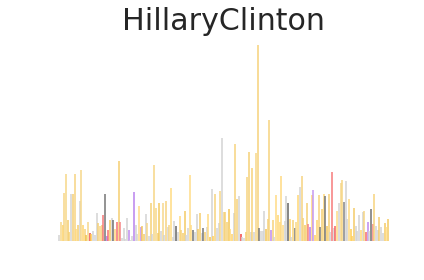

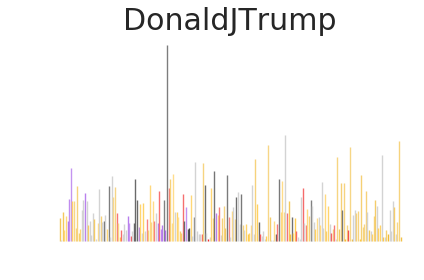

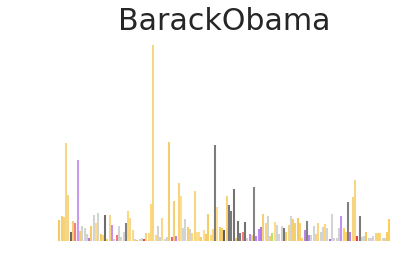

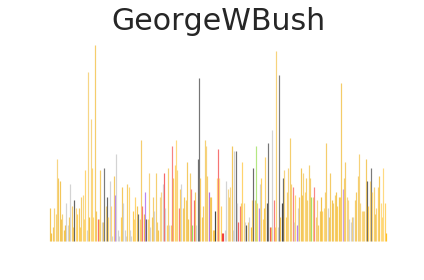

In [23]:
def make_rgb_transparent(color_name, bg_color_name, alpha):
    from matplotlib import colors
    rgb = colors.colorConverter.to_rgb(color_name)
    bg_rgb = colors.colorConverter.to_rgb(bg_color_name)
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

def f_plotsent_len(InDf, InTerm, InPresident):
    import numpy as np
    import pylab as pl
    from matplotlib import colors
    from math import sqrt
    from matplotlib import collections as mc

    col_use={"zero":"lightgray",
             "anger":"#ee0000",
             "anticipation":"#ffb90f",
             "disgust":"#66cd00",
             "fear":"blueviolet",
             "joy":"#eead0e",
             "sadness":"#1874cd", 
             "surprise":"#ffb90f",
             "trust":"#ffb90f",
             "negative":"black",
             "positive":"#eead0e"}
    
    InDf["top_emotion"] = InDf.loc[:,'anger':'trust'].idxmax(axis=1)
    InDf["top_emotion_value"] = InDf.loc[:,'anger':'trust'].max(axis=1)
    InDf.loc[InDf["top_emotion_value"] < 0.05, "top_emotion"] = "zero"
    InDf.loc[InDf["top_emotion_value"] < 0.05, "top_emotion_value"] = 1
    
    tempDf = InDf.loc[(InDf["president"]==InPresident)&(InDf["term"]==InTerm)]
    
    pt_col_use = []
    lines = []
    
    for i in tempDf.index:
        pt_col_use.append(make_rgb_transparent(col_use[tempDf.at[i,"top_emotion"]],
                         "white",
                         sqrt(sqrt(tempDf.at[i,"top_emotion_value"]))))
        lines.append([(i,0),(i,tempDf.at[i,"word_count"])])

    %matplotlib inline
    lc = mc.LineCollection(lines, colors=pt_col_use, linewidths=min(5,300/len(tempDf.index)))
    fig, ax = pl.subplots() #figsize=(15, 6)
    ax.add_collection(lc)
    ax.autoscale()
    ax.axis('off')
    plt.title(InPresident, fontsize=30)
    plt.tight_layout()
    plt.show()
    
f_plotsent_len(nomin_sen_df_with_emotion, '1', 'HillaryClinton')
f_plotsent_len(nomin_sen_df_with_emotion, '1', 'DonaldJTrump')
f_plotsent_len(nomin_sen_df_with_emotion, '1', 'BarackObama')
f_plotsent_len(nomin_sen_df_with_emotion, '1', 'GeorgeWBush')

### Clustering of emotions

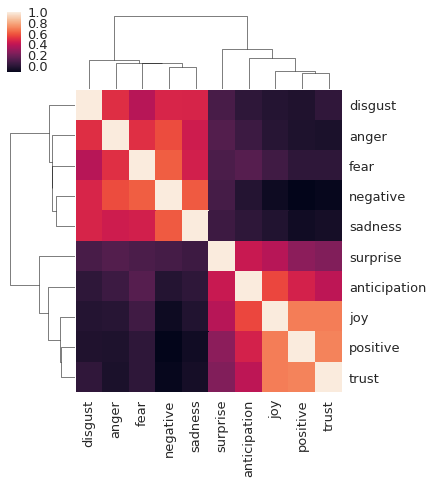

In [ ]:
sns.set(font_scale=1.3)
sns.clustermap(inaug_sen_df_with_emotion.loc[:,'anger':'trust'].corr(),
               figsize=(6,7))

In [ ]:
#Cell won't run
stemmer = PorterStemmer()

def tokenize_and_stem(text):
    lowers = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(lowers) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and not token in stopwords.words('english'):
            filtered_tokens.append(re.sub(r'[^\w\s]','',token))
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
    #return filtered_tokens

token_dict = {}
for fileid in inaug_corpus.fileids():
    token_dict[fileid] = inaug_corpus.raw(fileid)

# Construct a bag of words matrix.
# This will lowercase everything, and ignore all punctuation by default.
# It will also remove stop words.
vectorizer = CountVectorizer(lowercase=True, 
                             tokenizer=tokenize_and_stem, 
                             stop_words='english')

dtm = vectorizer.fit_transform(token_dict.values()).toarray()